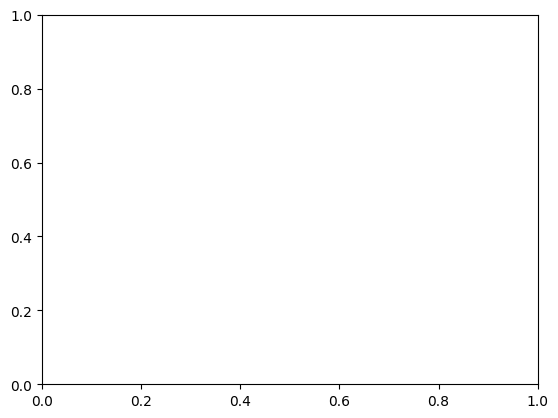

In [1]:
import os
CWD = os.path.abspath("")
os.chdir(CWD)
from collections import defaultdict
import pandas as pd
import csv
from utils import load_json, save_json, sanitize

from minedatabase.pickaxe import Pickaxe
from minedatabase.utils import get_compound_hash
from minedatabase.rules import metacyc_intermediate
from minedatabase.filters import (
    SimilarityFilter,
    SimilaritySamplingFilter,
)

from rdkit.Chem import CanonSmiles
from rdkit import Chem

str_dir = "../data/starters_targets_rules/"

input_cpds = str_dir + "succinate.csv"
target_cpds = str_dir + "mvacid.csv"
_, coreactant_list, rule_name = metacyc_intermediate(
    fraction_coverage=1
    # n_rules=5
)
rule_list = str_dir + 'JN3604IMT_rules.tsv'

In [2]:
pk = Pickaxe(
        coreactant_list=coreactant_list,
        rule_list=rule_list,
        errors=True,
        quiet=True,
        filter_after_final_gen=True,
    )

pk.load_compound_set(compound_file=input_cpds)

pk.load_targets(target_cpds)
tani_filter = False # True
tani_threshold = [0, 0, 0.3, 0.3, 0.3]
increasing_tani = False

tani_sample = True # False
sample_size = 1000 # 10
weight = None # 5

# Apply filters
if tani_filter:
    taniFilter = SimilarityFilter(
        crit_similarity=tani_threshold, increasing_similarity=increasing_tani
    )
    pk.filters.append(taniFilter)

if tani_sample:
    taniSampleFilter = SimilaritySamplingFilter(
        sample_size=sample_size, weight=weight
    )
    pk.filters.append(taniSampleFilter)
    pass

----------------------------------------
Intializing pickaxe object


RDKit WARNING: [16:25:19] WARNING: not removing hydrogen atom without neighbors
[16:25:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:25:19] WARNING: not removing hydrogen atom without neighbors
[16:25:19] WARNING: not removing hydrogen atom without neighbors



Done intializing pickaxe object
----------------------------------------

1 compounds loaded...
(1 after removing stereochemistry)
1 target compounds loaded



In [3]:
# pk.load_pickled_pickaxe("/projects/b1039/spn1560/bottle/succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk") # Load results
pk.load_pickled_pickaxe("../../data_from_quest/bottle/succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk") # Load results

Loading ../../data_from_quest/bottle/succinate_to_mvacid_gen_4_tan_sample_n_samples_1000.pk pickled data.
Loaded 89758 compounds
Loaded 106853 reactions
Loaded 3604 operators
Loaded 1 targets
Took 6.769839763641357


# Generate Pathways

In [4]:
from pathway_utils import create_graph_from_pickaxe

# Function to patch older results that weren't made with updated PickaxeGeneric code
def rename_smiles_reaction(pk):
    for rxn in pk.reactions.values():
        rxn["SMILES_rxn"] = rxn["SMILES_reaction"]
        
# Create the initial graph
DG, rxn, edge = create_graph_from_pickaxe(pk, "Biology")
starting_nodes = []
bad_nodes = []
for n in DG.nodes():
    try:
        if DG.nodes()[n]["Type"] == "Starting Compound":
            starting_nodes.append(n)
    except:
        bad_nodes.append(n)

RDKit ERROR: [16:25:51] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
[16:25:51] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: 
RDKit ERROR: [16:25:52] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[16:25:52] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [16:25:58] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
[16:25:58] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: 
RDKit ERROR: [16:25:59] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[16:25:59] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [16:25:59] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34
RDKit ERROR: 
[16:25:59] Can't kekulize mol.  Unkekulized atoms: 19 23 26 27 28 29 30 31 33 34

RDKit ERROR: [16:25:59] Can't kekulize mol.  Unkek

In [5]:
from minedatabase.pickaxe import Pickaxe
from minedatabase import utils

import PIL

from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from pathway_utils import (
    Pathway, count_cpds_and_rxns, get_reverse_paths_to_starting, path_to_generation, create_graph_from_pickaxe, add_nodes_from_pickaxe
)

def get_found_locations(smi):
    isin_list = []
    for key, val in df_stereo_matches.items():
        if smi in val:
            isin_list.append(key)
            
    return isin_list

class Pathways:
    def __init__(self, target_cid, pathways, DG, feas_dict):
        self.target_id = target_cid
        self.pathways = [Pathway(target_cid, pathway, DG, feas_dict) for pathway in pathways]

    @property
    def terminal_generation(self):
        return [pathway.terminal_generation for pathway in self.pathways]
    

# rules_to_exclude = ['rule0028_46']
# rules_to_exclude = ['rule0028_51', 'rule0028_46', 'rule0028_50', 'rule0043_12']
# rules_to_exclude = ['rule0028_51', 'rule0028_46', 'rule0028_50']
# rules_to_exclude = ['rule0028_50', 'rule0043_12']
rules_to_exclude = []

def contains_rule(pathway, DG):
    rules = set()
    for keyi in pathway.reaction_stoichs.keys():
        rules_i = DG.nodes()[keyi]["Rule"]
        rules.update(rules_i)

    for rule in rules_to_exclude:
        if rule in rules:
            return True
        
    return False

In [6]:
# Params
generations = 4
max_depth = generations*2
paths_dict = {}

# Fake feas dict
feas_dict = {rxn: True for rxn in [i for i in DG.nodes() if i.startswith("R")]}

# Specify Targets / Starting Cpds
target_smi = pk.target_smiles[0]
target_cids = [get_compound_hash(smi)[0] for smi in pk.target_smiles]
starting_cpds = [get_compound_hash(val["SMILES"])[0] for val in pk.compounds.values() if val["Type"].startswith("Start")]

# Loop through targets and get pathways from targets to starting compounds
for node in target_cids:
    paths = get_reverse_paths_to_starting(DG, begin_node=node, end_nodes=starting_cpds, max_depth=max_depth)
    # If we find paths then reverse those paths and assign to a dictionary
    if paths:
        paths_dict[node] = list(set([tuple(path[1::2]) for path in [[*reversed(ind_path)] for ind_path in paths]]))

target_cid = target_cids[0]
target_paths = [Pathway(target_cid, pathway, DG, feas_dict) for pathway in paths_dict[target_cid]]

pathways = Pathways(target_cid, paths_dict[target_cids[0]], DG, feas_dict)
pathways.pathways = [path for path in pathways.pathways if not (target_smi in path.sources)] # target is starting

len(pathways.pathways)

41

In [7]:
n = 0
paths = paths_dict[target_cids[0]][n]

i = 0
while i < len(paths):
    if contains_rule(pathways.pathways[i], DG):
        i += 1
    else:
        ix = i
        rxn_stoichs = pathways.pathways[ix].reaction_stoichs
        # print("Thermo", ix)
        # print("MDF ", pathways.pathways[ix].MDF)
        # print("Sequence ", pathways.pathways[ix].reaction_types)
        # print("Starting", pathways.pathways[ix].sources)
        # print("Sinks", pathways.pathways[ix].sinks)

        reactions = []
        for rxn_stoich in rxn_stoichs.values():
            products = ".".join([".".join([smi]*stoich) for smi, stoich in rxn_stoich.items() if stoich >= 0])
            reactants = ".".join([".".join([smi]*abs(stoich)) for smi, stoich in rxn_stoich.items() if stoich <= 0])

            reaction = ">>".join([reactants, products])
            reactions.append(reaction)

        ri = -1
        i +=1 

        # for keyi in pathways.pathways[ix].reaction_stoichs.keys():
        #     print(keyi, DG.nodes()[keyi])
        
        # print(reactions)
        break

rxn_images = [
    Draw.ReactionToImage(
        AllChem.ReactionFromSmarts(rxn, useSmiles=True),
        subImgSize=(200, 200), useSVG=False, drawOptions=None, returnPNG=False
    ) for rxn in reactions
]

def get_concat_v(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# image = rxn_images[0]
# for rxn_image in rxn_images[1:]:
#     image = get_concat_v(image, rxn_image)

# image

In [9]:
# for i in range(len(pathways.pathways)):
#     if contains_rule(pathways.pathways[i], DG):
#         print('bad rule')

In [8]:
i = 0
j = 0

0
R676b7e7fa1db3c3666238582c19b6c4c3af744ffe410cbca60b8a97b98f6e6cb {'bipartite': 1, 'Rule': {'rule0126_1'}, 'Type': 'Biology', 'Stoich': {'O=C(O)CCC(=O)O': -2, 'O=CO': 1, 'O=C(O)CCC(CC(=O)O)C(=O)O': 1}, 'feasible': None, 'Reactants': [(2, 'C4fe83a533b208e245e45b74e0967d7b8e9aad361')], 'Products': [(1, 'C0e2c8d649fd28524ed617a741b4da1c714899166'), (1, 'C84eb18413dba85e1b4a25e9e8455948560c323c7')]} 

R2dfbfec9fdccd58700b6b82be19b3129ff10762e5c56fc975ea54d7f73002ed8 {'bipartite': 1, 'Rule': {'rule0018_54', 'rule0018_71', 'rule0018_61'}, 'Type': 'Biology', 'Stoich': {'O=C(O)CCC(CC(=O)O)C(=O)O': -1, 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': -1, 'O=C(O)C=C(CCC(=O)O)C(=O)O': 1, 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1}, 'feasible': None, 'Reactants': [(1, 'C84eb18413dba85e1b4a25e9e8455948560c323c7'), (1, 'X151d45ce062c088336cff9e45bc138b6a63626fe')], 'Products': [(1, 'X281e38d790b809dc

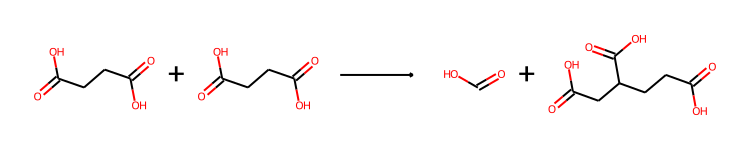

In [11]:
i=0

paths = paths_dict[target_cids[0]][i]

print(i)
rxn_stoichs = pathways.pathways[i].reaction_stoichs

while contains_rule(pathways.pathways[i], DG):
    # print(i)
    i += 1

reactions = []
for rxn_stoich in rxn_stoichs.values():
    products = ".".join([".".join([smi]*stoich) for smi, stoich in rxn_stoich.items() if stoich >= 0])
    reactants = ".".join([".".join([smi]*abs(stoich)) for smi, stoich in rxn_stoich.items() if stoich <= 0])

    reaction = ">>".join([reactants, products])
    reactions.append(reaction)

for keyi in pathways.pathways[i].reaction_stoichs.keys():
    print(keyi, DG.nodes()[keyi], '\n')

AllChem.ReactionFromSmarts(reactions[0], useSmiles=True)


In [16]:
# Sort pathways into unique combinations of reaction rules

# Each transformation in a pathway
# has one or multiple rules associated w it
rule_set_2_id = {} # Maps a set of rules to an integer id
combo_2_pwy_idx = defaultdict(list) # Maps a combination of rule sets to pway index
idx = 0 # For pway index

for i in range(len(pathways.pathways)):
    this_combo = []
    for keyi in pathways.pathways[i].reaction_stoichs.keys():
        this_rule_set = tuple(sorted(DG.nodes()[keyi]['Rule']))
        if this_rule_set not in rule_set_2_id:
            rule_set_2_id[this_rule_set] = idx
            idx += 1

id_2_rule_set = {v:k for k,v in rule_set_2_id.items()} # Map back from id to rule set
        

for i in range(len(pathways.pathways)):
    this_combo = []
    for keyi in pathways.pathways[i].reaction_stoichs.keys():
        this_rule_set = tuple(sorted(DG.nodes()[keyi]['Rule']))
        this_combo.append(rule_set_2_id[this_rule_set])

    this_combo = tuple(sorted(this_combo))
    combo_2_pwy_idx[this_combo].append(i)

In [17]:
print(len(combo_2_pwy_idx.keys())) # Number of unique rule combinations
print([len(v) for k,v in combo_2_pwy_idx.items()]) # Degeneracy of rule combos

17
[8, 3, 1, 3, 1, 8, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1]


In [18]:
# Load in IMT rule mapping

# Load rules
rules_path = '../data/starters_targets_rules/JN3604IMT_rules.tsv'
all_rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        all_rules.append(row[0])

all_rules = all_rules[1:]
rule_df = pd.read_csv(rules_path, delimiter='\t')
rule_df.set_index('Name', inplace=True)

# Load mapping

all_rxns = []
mapped_rxns = []
unmapped_rxns = []
rxn2rule = {}

db_names = ['_mc_v21', '_brenda', '_kegg']
suffix = '_imt_rules_enforce_cof.csv'
for name in db_names:
    mapping_path = '../data/mapping/mapping' + name + suffix
    with open(mapping_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_rxns.append(row[0])
            if len(row) == 1:
                unmapped_rxns.append(row[0])
                rxn2rule[row[0]] = []
            else:
                mapped_rxns.append(row[0])
                rxn2rule[row[0]] = row[1:]

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))


# Make rule2rxn
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

# Load all known reactions into dict
known_rxns = {}
pref = '../data/mapping/'
suffs = ['mc_v21_as_is.json', 'brenda_as_is.json', 'kegg_as_is.json']

for elt in suffs:
    known_rxns.update(load_json(pref + elt))

Mapping fraction: 0.7036698550158826
Total # reactions analyzed: 112702


In [19]:
# Look up known reactions mapped by each rule set used
id_2_mapped_rxns = defaultdict(list)
for k,v in rule_set_2_id.items():
    for elt in k:
        id_2_mapped_rxns[v] += rule2rxn[elt]

print([(k, len(v)) for k,v in id_2_mapped_rxns.items()])

[(0, 40), (1, 29), (2, 88), (3, 23), (4, 9), (5, 18), (6, 9), (7, 9), (8, 47), (9, 20), (10, 29)]


In [20]:
# Look up most mapped EC number for each rule (set)

# Load imt ec number csv
ec_df = pd.read_csv('../data/mapping/imt_rules_top_ec_numbers.csv', sep=',')
ec_df.set_index('rule', inplace=True)
ec_df.head()

for k,v in id_2_rule_set.items():
    for elt in v:
        if elt in ec_df.index:
            print(k, ec_df.loc[elt, 'top_3rd_digit'])
        # else:
        #     print(k, v)

0 1.1.99
2 2.8.3
3 1.2.1
4 1.3.5
5 4.1.1
5 4.1.3
7 4.1.99
8 3.7.1
9 1.3.1
10 4.1.1


In [21]:
combo_2_pwy_idx

defaultdict(list,
            {(0, 1, 2, 3): [0, 6, 7, 8, 13, 21, 23, 28],
             (0, 3, 4, 5): [1, 4, 31],
             (2, 3, 6, 7): [2],
             (0, 0, 1, 3): [3, 5, 15],
             (0, 3, 8, 9): [9],
             (0, 2, 3, 4): [10, 11, 19, 24, 26, 30, 33, 36],
             (0, 3, 7, 9): [12],
             (0, 0, 3, 4): [14, 22, 27],
             (2, 3, 4, 7): [16],
             (0, 1, 3, 5): [17, 29, 34],
             (0, 0, 3, 9): [18, 20, 38],
             (3, 7, 9, 10): [25],
             (0, 2, 3, 9): [32],
             (3, 4, 5, 7): [35],
             (0, 3, 9, 10): [37],
             (3, 7, 8, 9): [39],
             (3, 5, 6, 7): [40]})

In [45]:
i = 0 # Pwy id
j = -1 # Pred rxn id


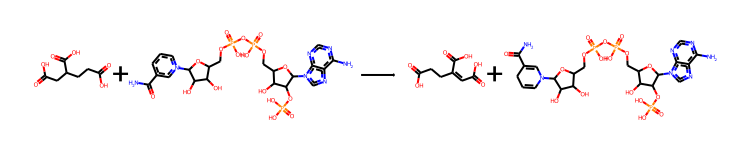

In [47]:
j+=1
rxn_stoichs = pathways.pathways[i].reaction_stoichs
dg_key = list(pathways.pathways[i].reaction_stoichs.keys())[j]
rule_set = tuple(sorted(DG.nodes()[dg_key]['Rule']))
rule_id = rule_set_2_id[rule_set]

nad_smi = CanonSmiles('C1=C(-C(=O)-N)-C=C-C=[N+]-1-*')
nadh_smi = CanonSmiles('C1=C(-C(=O)-N)-C-C=C-N-1-*')
succ_coa_smi = CanonSmiles('*SC(=O)CCC(=O)O')
benz_succ_coa_smi = CanonSmiles('*SC(=O)[C@@H](CC(=O)O)Cc1ccccc1')
prop_coa_smi = CanonSmiles('CCC(=O)S*')
d_methyl_malonyl_coa_smi = CanonSmiles('C[C@@H](C(=O)O)C(=O)S*')

short_lut = {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': nadh_smi,
             'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': nad_smi, 
             'NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1': nadh_smi,
             'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1': nad_smi,
             'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': nad_smi,
             'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': nadh_smi,
             'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCC(=O)O': succ_coa_smi,
             'CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)[C@@H](CC(=O)O)Cc1ccccc1': benz_succ_coa_smi,
             'CCC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O': prop_coa_smi,
             'C[C@@H](C(=O)O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)(O)O': d_methyl_malonyl_coa_smi
             
             }

short_lut = {}

reactions = []
for rxn_stoich in rxn_stoichs.values():
    reactants = []
    products = []
    for smi, stoich in rxn_stoich.items():
        if smi in short_lut:
                this_smi = short_lut[smi]
        else:
            this_smi = smi

        if stoich >= 0:
             products.append(".".join([this_smi] * stoich))
        elif stoich <= 0:
             reactants.append(".".join([this_smi] * abs(stoich)))

    reaction = ">>".join([".".join(reactants), ".".join(products)])
    reactions.append(reaction)


AllChem.ReactionFromSmarts(reactions[j], useSmiles=True)

In [60]:
reactions[j]

'O=C(O)CCC(CC(=O)O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1>>O=C(O)C=C(CCC(=O)O)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1'

In [48]:
k = 0

1.3.1.31_57
8


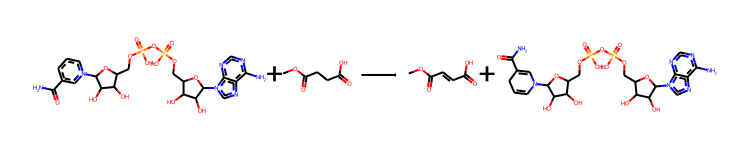

In [57]:
# k = 2 # Mapped known rxn list index
mapped_entry = known_rxns[id_2_mapped_rxns[rule_id][k]]
print(id_2_mapped_rxns[rule_id][k])
mapped_rxn = []
reactants = ".".join(mapped_entry[0].values())
products = ".".join(mapped_entry[1].values())

temp_reactants, temp_products = [], []
for elt in reactants.split('.'):
    if elt in short_lut:
        temp_reactants.append(short_lut[elt])
    else:
        temp_reactants.append(elt)

for elt in products.split('.'):
    if elt in short_lut:
        temp_products.append(short_lut[elt])
    else:
        temp_products.append(elt)

reactants, products = ".".join(temp_reactants), ".".join(temp_products)

mapped_rxn = ">>".join([reactants, products])
print(k)
k += 1
AllChem.ReactionFromSmarts(mapped_rxn, useSmiles=True)

In [59]:
known_rxns[id_2_mapped_rxns[rule_id][k]]

[{'(2R)-2-methylbutanedioic acid:0': 'CC(CC(=O)O)C(=O)O',
  'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
 {'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1',
  'citraconic acid:0': 'CC(=CC(=O)O)C(=O)O'}]

In [62]:
# for elt in id_2_mapped_rxns[rule_id]:
#     print(known_rxns[elt])

In [203]:
mapped_entry

[{'2-isopropyl-5-methylhexanal:0': 'CC(C)CCC(C=O)C(C)C',
  'NAD+:0': 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'},
 {'2-isopropyl-5-methyl-2-hexenal:0': 'CC(C)CC=C(C=O)C(C)C',
  'NADH:0': 'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1'}]

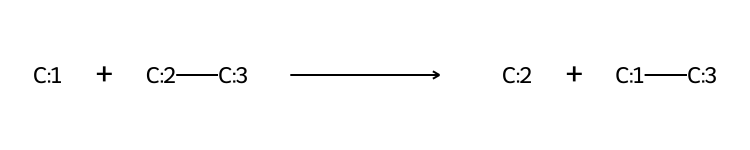

In [23]:
rule = '[#6;$([#6&!R]-[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):1].[#6;$([#6&!R]-&!@[#6&!R]):2]-[#6:3]>>[#6:2].[#6:1]-[#6:3]'
AllChem.ReactionFromSmarts(rule)

In [21]:
from rxnmapper import RXNMapper
rxnmapper = RXNMapper()

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expec

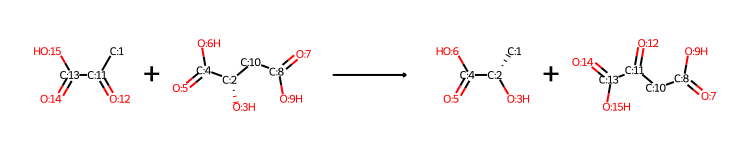

In [38]:
um_rxn = ".".join(mapped_entry[0].values()) + '>>' + ".".join(mapped_entry[1].values())
res = rxnmapper.get_attention_guided_atom_maps([um_rxn])
m_rxn = res[0]['mapped_rxn']
AllChem.ReactionFromSmarts(m_rxn, useSmiles=True)

In [44]:
def sanitize(list_of_smiles):
    sanitized_smiles = []
    for elt in list_of_smiles:
        temp_mol = Chem.MolFromSmiles(elt)
        Chem.rdmolops.RemoveStereochemistry(temp_mol)
        sanitized_smiles.append(Chem.MolToSmiles(temp_mol))    
    return sanitized_smiles

['CC(O)C(=O)O', 'O=C(O)CC(=O)C(=O)O']


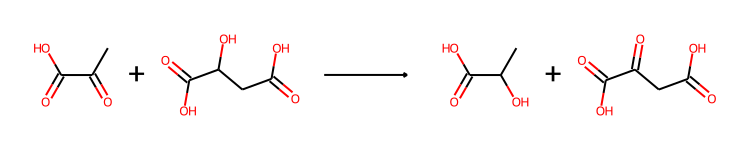

In [58]:
operator = Chem.rdChemReactions.ReactionFromSmarts(rule)
rs = sanitize(um_rxn.split('>>')[0].split('.'))
rs.reverse()
ps = sanitize(sorted(um_rxn.split('>>')[1].split('.')))
r_mol = tuple([Chem.MolFromSmiles(elt) for elt in rs])
outputs = operator.RunReactants(r_mol)

matched_output = None
for elt in outputs:
    this_os = sorted([Chem.MolToSmiles(o) for o in elt])
    if this_os == ps:
        print(this_os)
        matched_output = this_os

recap_rxn = '.'.join(rs) + '>>' + '.'.join(matched_output)
AllChem.ReactionFromSmarts(recap_rxn, useSmiles=True)

In [53]:
recap_rxn

'CC(=O)C(=O)O.O=C(O)CC(O)C(=O)OCC(O)C(=O)O>>.O=C(O)CC(=O)C(=O)O'

In [55]:
um_rxn

'O=C(O)C[C@H](O)C(=O)O.CC(=O)C(=O)O>>C[C@H](O)C(=O)O.O=C(O)CC(=O)C(=O)O'

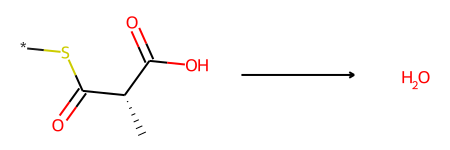

In [511]:
smi = CanonSmiles('C[C@@H](C(=O)O)C(=O)S*')
AllChem.ReactionFromSmarts(smi + '>>' + 'O', useSmiles=True)

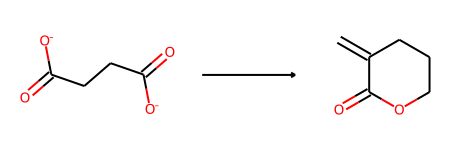

In [407]:
mvl_smi = 'C1(C(CCCO1)=C)=O'
succ_smi = 'C(CC(=O)[O-])C(=O)[O-]'
ha_mvl_prec_smi = 'C=C(CCCO)C(=O)O'

AllChem.ReactionFromSmarts(succ_smi + '>>' + mvl_smi, useSmiles=True)

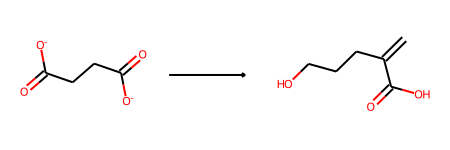

In [408]:
AllChem.ReactionFromSmarts(succ_smi + '>>' + ha_mvl_prec_smi, useSmiles=True)

In [208]:
foo = load_json('/home/stef/Tb/reaction_mapping/jos_rxn_data/metacyc.json')
foo

{'RXN-12199': [{'Pi:0': 'O=P(O)(O)O',
   'Pi:1': 'O=P(O)(O)O',
   'UMP:0': 'O=c1ccn([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1'},
  {'UTP:0': 'O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1',
   'WATER:0': 'O',
   'WATER:1': 'O'},
  'A0JND9,B3A0N5,E0D877,F4JSH1,O18956,O75355,O80612,O93295,O96559,P40009,P49961,P50635,P55772,P80595,P97687,Q2QYE1,Q5DRK1,Q5MY95,Q6NQA8,Q6Z4P2,Q8H1D8,Q8H7L6,Q8K0L2,Q9FVC2,Q9FVC3,Q9MYU4,Q9SPM5,Q9SQG2,Q9USP2,Q9XI62,Q9Y5L3',
  'Unmapped'],
 'RXN-12199_reverse': [{'UTP:0': 'O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1',
   'WATER:0': 'O',
   'WATER:1': 'O'},
  {'Pi:0': 'O=P(O)(O)O',
   'Pi:1': 'O=P(O)(O)O',
   'UMP:0': 'O=c1ccn([C@@H]2O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]2O)c(=O)[nH]1'},
  'A0JND9,B3A0N5,E0D877,F4JSH1,O18956,O75355,O80612,O93295,O96559,P40009,P49961,P50635,P55772,P80595,P97687,Q2QYE1,Q5DRK1,Q5MY95,Q6NQA8,Q6Z4P2,Q8H1D8,Q8H7L6,Q8K0L2,Q9FVC2,Q9FVC3,Q9MYU4,Q9SPM5,Q9SQG2,Q9USP2